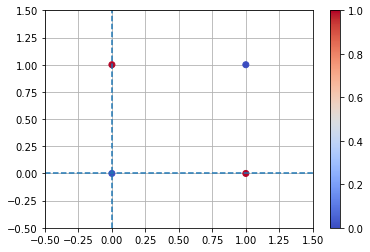

In [48]:
# A notebook alapú megjelenítés aktiválása 
# (részletek: https://ipython.readthedocs.io/en/stable/interactive/plotting.html)
%matplotlib inline 
import matplotlib.pyplot as plt # Pyplot grafikus megjelenítocsomag importálása
plt.rc('axes', axisbelow=True)  # Csinosítás: Rács, tengelyek, a grafikonok mögött

# A és B -> x és y bemeneti kombinációi és kimeneti értékek xor
xs   = [0, 1, 0, 1]
ys   = [0, 0, 1, 1]
xor  = [0, 1, 1, 0]
and_ = [0, 0, 0, 1]
or_  = [0, 1, 1, 1]

# Pontok ábrázolása. Piros -> 1 (Igaz), Kék-> 0(Hamis)
plt.scatter(xs, ys, c=xor, cmap='coolwarm')
# Megj.: megnézhetjünk 'c=and'_ és 'c=or_'-ral is a plottolást

# Csinosítás
# Színskála hozzáadása
plt.colorbar()

# A jobb ábrázálhatóság miatt, szélesebb tartományokat jelenítünk meg
plt.xlim(-0.5, 1.5) 
plt.ylim(-0.5, 1.5)

# Négyzetrács megjelenítése
plt.grid(True)

# Az x és y tengely megjelenítése
plt.axhline(0, linestyle='dashed')
plt.axvline(0, linestyle='dashed');

In [49]:
import numpy as np

In [50]:
def activation(x): 
    return 1.0/ (1.0+np.exp(-x))

In [51]:
segedX = np.linspace(-6,6,200)

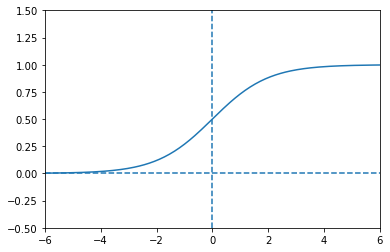

In [52]:
y = activation(segedX)
plt.plot(segedX, y)

# A jobb ábrázálhatóság miatt, szélesebb tartományokat jelenítünk meg
plt.xlim(-6, 6)
plt.ylim(-0.5, 1.5)
# Az x és y tengely megjelenítése
plt.axhline(0, linestyle='dashed')
plt.axvline(0, linestyle='dashed');

In [53]:
from sklearn import preprocessing

In [54]:
def dactivation(x):
    return np.exp(-x)/((1+np.exp(-x))**2)

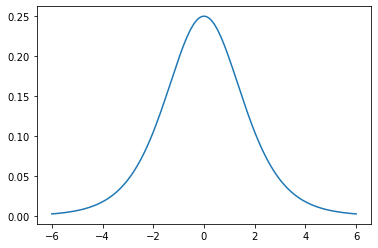

In [55]:
plt.plot(segedX, dactivation(segedX))

In [56]:
class MLP: 
    def __init__(self,*args):
        np.random.seed(123)
        self.shape = args
        n = len(args)
        self.layers = []
        self.layers.append(np.ones(self.shape[0]+1)) # +1: bias

        for i in range(1,n):
            self.layers.append(np.ones(self.shape[i]))
        self.weights = []
        for i in range(n-1):
            self.weights.append(np.zeros((self.layers[i].size, self.layers[i+1].size)))
        self.dw = [0, ] * len(self.weights)
        self.reset()

    def reset(self):
        for i in range(len(self.weights)):
            Z = np.random.random((self.layers[i].size, self.layers[i+1].size))

            self.weights[i][...] = (2 * Z - 1) * 1

    def propagate_forward(self, data):
        self.layers[0][0:-1] = data

        for i in range(1, len(self.shape)):
            self.layers[i][...] = activation(np.dot(self.layers[i-1], self.weights[i-1]))

        return self.layers[-1]
    
    def propagate_backward(self,target,lrate=0.1):
        deltas = []
        error = - (target-self.layers[-1]) # y - y_kalap
        delta = np.multiply(error, dactivation(np.dot(self.layers[-2], self.weights[-1])))
        deltas.append(delta)
        #deltas.insert(0, delta) # ugyanaz
        for i in range(len(self.shape)-2,0,-1):
            delta = np.dot(deltas[0], self.weights[i].T)*dactivation(np.dot(self.layers[i-1], self.weights[i-1]))
            deltas.insert(0, delta)

        for i in range(len(self.weights)):
            layer = np.atleast_2d(self.layers[i])
            delta = np.atleast_2d(deltas[i])
            dw = -lrate*np.dot(layer.T,delta)
            self.weights[i] += dw
            self.dw[i] = dw
        
        return (error**2).sum()

In [57]:
def learn (network, X, Y, valid_split, test_split, epochs=20, lrate=0.1):
        X_train = X[0:int(nb_samples*(1-valid_split-test_split))]
        Y_train = Y[0:int(nb_samples*(1-valid_split-test_split))]
        X_valid = X[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
        Y_valid = Y[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
        X_test = X[int(nb_samples*(1-test_split)):]
        Y_test = Y[int(nb_samples*(1-test_split)):]

       # standardizálás
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_valid = scaler.transform(X_valid)
        X_test  = scaler.transform(X_test)
    
        # ugyanolyan sorrendben keverjük be a bemeneteket és kimeneteket, a három külön adatbázisra
        randperm = np.random.permutation(len(X_train))
        X_train, Y_train = X_train[randperm], Y_train[randperm]
        
              
        # Tanítási fázis, epoch-szor megyünk át 1-1 véltelenszerűen kiválasztott mintán.
        for i in range(epochs):
            # Jelen megoldás azt a módszert használja, hogy a megadott 
            # tanító adatokon végigmegyünk és minden elemet először végigküldünk
            # a hálózaton, majd terjeszti vissza a kapott eltérést az
            # elvárt eredménytől. Ezt hívjuk SGD-ek (stochastic gradient descent).
            train_err = 0
            for k in range(X_train.shape[0]):
                network.propagate_forward( X_train[k] )
                train_err += network.propagate_backward( Y_train[k], lrate )
            train_err /= X_train.shape[0]

            # validációs fázis
            valid_err = 0
            o_valid = np.zeros(X_valid.shape[0])
            for k in range(X_valid.shape[0]):
                o_valid[k] = network.propagate_forward(X_valid[k])
                valid_err += (o_valid[k]-Y_valid[k])**2
            valid_err /= X_valid.shape[0]
            

            print("%d epoch, train_err: %.4f, valid_err: %.4f" % (i, train_err, valid_err))

        # Tesztelési fázis
        print("\n--- TESZTELÉS ---\n")
        test_err = 0
        o_test = np.zeros(X_test.shape[0])
        for k in range(X_test.shape[0]):
            o_test[k] = network.propagate_forward(X_test[k])
            test_err += (o_test[k]-Y_test[k])**2
            print(k, X_test[k], '%.2f' % o_test[k], ' (elvart eredmeny: %.2f)' % Y_test[k])
        test_err /= X_test.shape[0]

        plt.scatter(X_test[:,0], X_test[:,1], c=np.round(o_test[:]), cmap=plt.cm.coolwarm)
  

In [58]:
network = MLP(2,10,1)

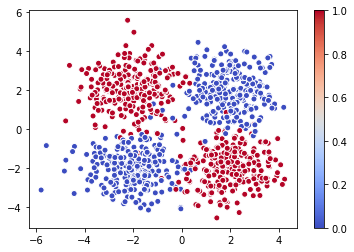

In [59]:
nb_samples=1000
X = np.zeros((nb_samples,2))
Y = np.zeros(nb_samples)
for i in range(0,nb_samples,4):
    noise = np.random.normal(0,1,8)
    X[i], Y[i] = (-2+noise[0],-2+noise[1]), 0
    X[i+1], Y[i+1] = (2+noise[2],-2+noise[3]), 1
    X[i+2], Y[i+2] = (-2+noise[4],2+noise[5]), 1
    X[i+3], Y[i+3] = (2+noise[6],2+noise[7]), 0

# ...és az adatok kirajzolása
plt.scatter(X[:,0],X[:,1],c=Y[:], cmap=plt.cm.coolwarm, linewidth=1, edgecolors='w')
plt.colorbar();

0 epoch, train_err: 0.2461, valid_err: 0.2378
1 epoch, train_err: 0.2297, valid_err: 0.2212
2 epoch, train_err: 0.2070, valid_err: 0.1934
3 epoch, train_err: 0.1742, valid_err: 0.1585
4 epoch, train_err: 0.1387, valid_err: 0.1267
5 epoch, train_err: 0.1098, valid_err: 0.1035
6 epoch, train_err: 0.0897, valid_err: 0.0879
7 epoch, train_err: 0.0764, valid_err: 0.0773
8 epoch, train_err: 0.0673, valid_err: 0.0700
9 epoch, train_err: 0.0610, valid_err: 0.0647
10 epoch, train_err: 0.0564, valid_err: 0.0606
11 epoch, train_err: 0.0529, valid_err: 0.0575
12 epoch, train_err: 0.0502, valid_err: 0.0551
13 epoch, train_err: 0.0480, valid_err: 0.0531
14 epoch, train_err: 0.0462, valid_err: 0.0514
15 epoch, train_err: 0.0447, valid_err: 0.0500
16 epoch, train_err: 0.0434, valid_err: 0.0488
17 epoch, train_err: 0.0422, valid_err: 0.0477
18 epoch, train_err: 0.0413, valid_err: 0.0468
19 epoch, train_err: 0.0404, valid_err: 0.0460

--- TESZTELÉS ---

0 [-0.49551261 -0.7444607 ] 0.18  (elvart eredmeny

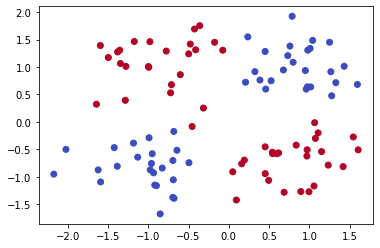

In [60]:
# Tanítás/Tesztelés indítása
network.reset()
valid_split = 0.2; test_split = 0.1
learn(network, X, Y, valid_split, test_split)